In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16
from keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['tulips', 'daisy', 'roses', 'dandelion', 'sunflowers']


In [ ]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Normalize data first:

X_normalized = X/255.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [ ]:
# Delete unused data, to prevent RAM from going boom

del(X)
del(X_normalized)

In [ ]:
# Sequence of modules to place before the actual NN

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
# Encode classes in valid format

y_train_encoded = to_categorical(y_train, 5)
y_val_encoded = to_categorical(y_val, 5)

In [ ]:
# Load and freeze pretrained model
pretrained_layer = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=(224, 224, 3))
])
pretrained_layer.trainable = False

# Add custom layers
pretrained_model_aug = keras.Sequential([
    data_augmentation,
    pretrained_layer,
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

# Compile the model
pretrained_model_aug.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Fit model with callbacks
history = pretrained_model_aug.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
92/92 [==============================] - 14s 85ms/step - loss: 0.9728 - accuracy: 0.6287 - val_loss: 0.5508 - val_accuracy: 0.8038
Epoch 2/30
92/92 [==============================] - 5s 51ms/step - loss: 0.5592 - accuracy: 0.8031 - val_loss: 0.4347 - val_accuracy: 0.8610
Epoch 3/30
92/92 [==============================] - 5s 50ms/step - loss: 0.4914 - accuracy: 0.8181 - val_loss: 0.4056 - val_accuracy: 0.8610
Epoch 4/30
92/92 [==============================] - 5s 51ms/step - loss: 0.4288 - accuracy: 0.8409 - val_loss: 0.3979 - val_accuracy: 0.8529
Epoch 5/30
92/92 [==============================] - 5s 51ms/step - loss: 0.4017 - accuracy: 0.8566 - val_loss: 0.3839 - val_accuracy: 0.8692
Epoch 6/30
92/92 [==============================] - 5s 51ms/step - loss: 0.3951 - accuracy: 0.8569 - val_loss: 0.3575 - val_accuracy: 0.8719
Epoch 7/30
92/92 [==============================] - 5s 51ms/step - loss: 0.3629 - accuracy: 0.8713 - val_loss: 0.3573 - val_accuracy: 0.8747
Epoch 8/30
9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

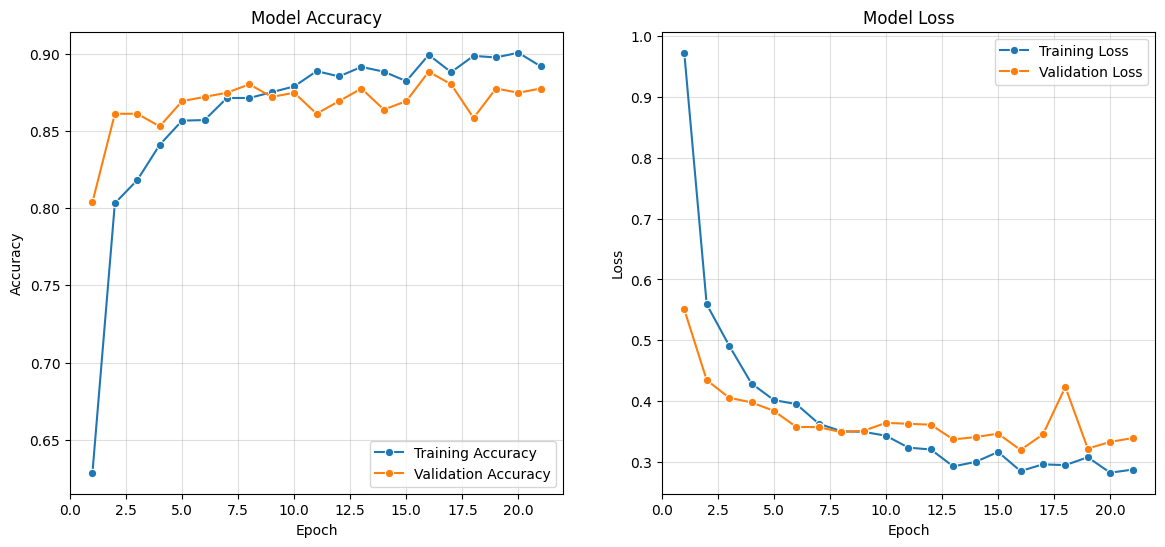

In [ ]:
# Assuming you have the history dictionary loaded
history_dict = history.history

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history_dict)

# Add an epoch column
history_df['epoch'] = history_df.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.4)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.4)
plt.savefig("accuracy_trained.png")
files.download("accuracy_trained.png")

12/12 [==============================] - 1s 40ms/step
Confusion Matrix:
[[81  0  3  2  1]
 [ 1 50  1  4  1]
 [10  1 57  0  0]
 [ 0  1  0 75  5]
 [ 4  1  0  2 67]]


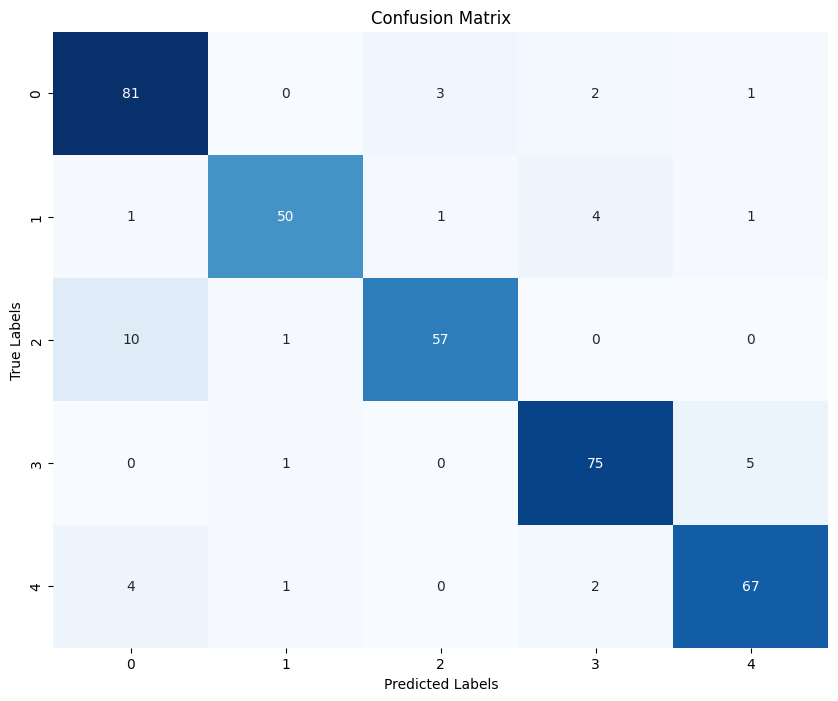

In [ ]:
y_pred = pretrained_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Compute F1 scores for each class
f1_scores = f1_score(y_test, y_pred_classes, average=None)
mean_f1_score = np.mean(f1_scores)

# Print F1 scores
print("F1 Scores for each class:")
for i, score in enumerate(f1_scores):
    print(f"Class {i}: {score:.2f}")

# Print mean F1 score
print(f"Mean F1 Score: {mean_f1_score:.4f}")

F1 Scores for each class:
Class 0: 0.89
Class 1: 0.91
Class 2: 0.88
Class 3: 0.91
Class 4: 0.91
Mean F1 Score: 0.8996


In [ ]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_transfer_learning.keras'
pretrained_model_aug.save(model_save_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---

In [ ]:
pretrained_layer.trainable = True

# Fine-tune from this layer onwards
fine_tuning = 130

# Freeze all the layers before fine_tuned_ind
for layer in pretrained_layer.layers[:fine_tuning]:
    layer.trainable =  False

In [ ]:
# set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00001)

# Recompile the model with a lower learning rate for fine-tuning
pretrained_model_aug.compile(
    optimizer=Adam(learning_rate=1e-4),  # 1/100 original LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = pretrained_model_aug.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
92/92 [==============================] - 8s 69ms/step - loss: 0.2842 - accuracy: 0.8954 - val_loss: 0.3290 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 2/100
92/92 [==============================] - 4s 48ms/step - loss: 0.2755 - accuracy: 0.9019 - val_loss: 0.3301 - val_accuracy: 0.8828 - lr: 1.0000e-04
Epoch 3/100
92/92 [==============================] - 5s 51ms/step - loss: 0.2761 - accuracy: 0.8992 - val_loss: 0.3308 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 4/100
92/92 [==============================] - 5s 52ms/step - loss: 0.2715 - accuracy: 0.9070 - val_loss: 0.3268 - val_accuracy: 0.8747 - lr: 1.0000e-04
Epoch 5/100
92/92 [==============================] - 5s 49ms/step - loss: 0.2751 - accuracy: 0.8992 - val_loss: 0.3243 - val_accuracy: 0.8856 - lr: 1.0000e-04
Epoch 6/100
92/92 [==============================] - 5s 50ms/step - loss: 0.2780 - accuracy: 0.8992 - val_loss: 0.3257 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 7/100
92/92 [===========================

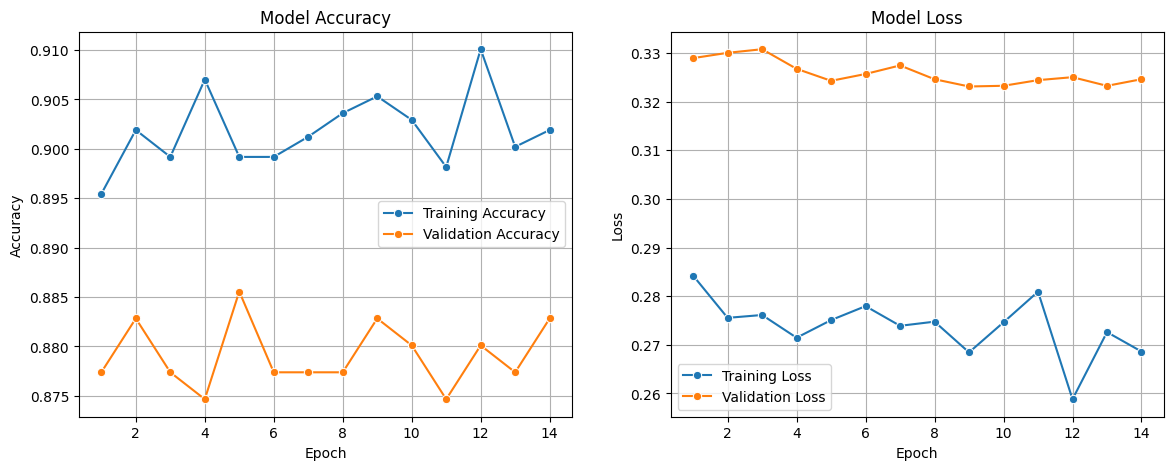

In [ ]:
# Assuming you have the history dictionary loaded
history_dict_fine = history_finetune.history

# Create a DataFrame from the history dictionary
history_df_fine = pd.DataFrame(history_dict_fine)

# Add an epoch column
history_df_fine['epoch'] = history_df_fine.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_fine, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df_fine, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_fine, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df_fine, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.grid(True)

12/12 [==============================] - 1s 38ms/step
Confusion Matrix:
[[79  2  5  0  1]
 [ 0 50  2  4  1]
 [ 6  1 61  0  0]
 [ 0  1  0 77  3]
 [ 5  1  1  2 65]]


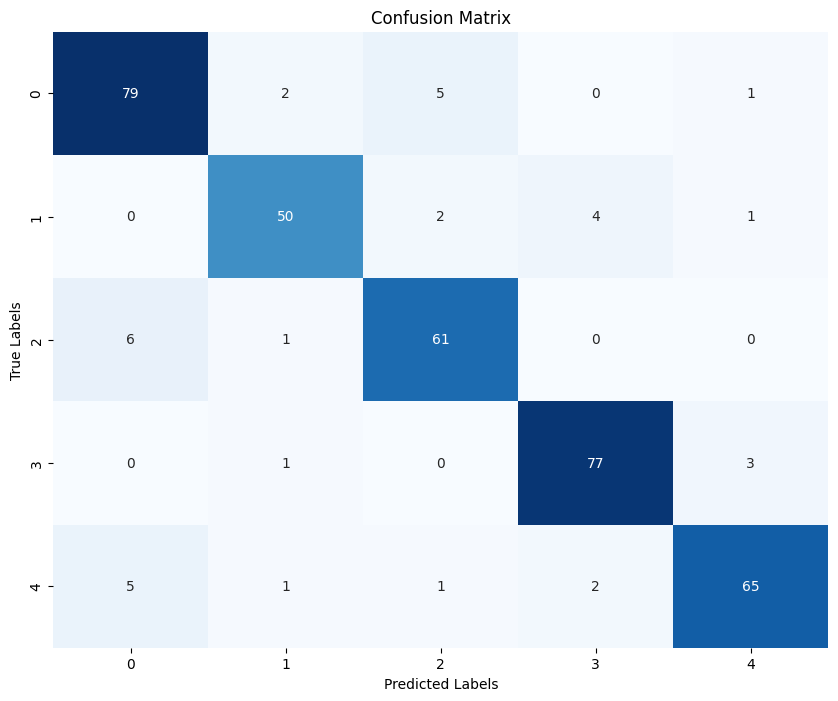

In [ ]:
y_pred1 = pretrained_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes1 = np.argmax(y_pred1, axis=1)

# Now you can compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred_classes1)

# Print confusion matrix
print("Confusion Matrix:")
print(cm1)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Compute F1 scores for each class
f1_scores1 = f1_score(y_test, y_pred_classes1, average=None)
mean_f1_score1 = np.mean(f1_scores1)

# Print F1 scores
print("F1 Scores for each class:")
for i, score in enumerate(f1_scores1):
    print(f"Class {i}: {score:.2f}")

# Print mean F1 score
print(f"Mean F1 Score: {mean_f1_score1:.4f}")

F1 Scores for each class:
Class 0: 0.89
Class 1: 0.89
Class 2: 0.89
Class 3: 0.94
Class 4: 0.90
Mean F1 Score: 0.9036


In [ ]:
epochs_0 = 15

def plot_history_fined(history, history_finetune, initial_epochs=epochs_0, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """

    acc = history.history['accuracy'][:epochs_0]
    acc += history_finetune.history['accuracy']
    val_acc = history.history['val_accuracy'][:epochs_0]
    val_acc += history_finetune.history['val_accuracy']

    loss = history.history['loss'][:epochs_0]
    loss += history_finetune.history['loss']
    val_loss = history.history['val_loss'][:epochs_0]
    val_loss += history_finetune.history['val_loss']


    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 6))
    ax1.plot(acc, label='Training', marker='o', ls='-')
    ax1.plot(val_acc, label='Validation', marker='o', ls='-')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', xlabel='epochs', title='Training - Validation Accuracy',
            ylim=([0.6,1.005]))
    ax1.grid(True, alpha=0.4)

    ax2.plot(loss, label='Training', marker='o', ls='-')
    ax2.plot(val_loss, label='Validation', marker='o', ls='-')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [0,1] , label='fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    ax2.grid(True, alpha=0.4)

    plt.savefig("finetuned_result.png")
    files.download("finetuned_result.png")
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

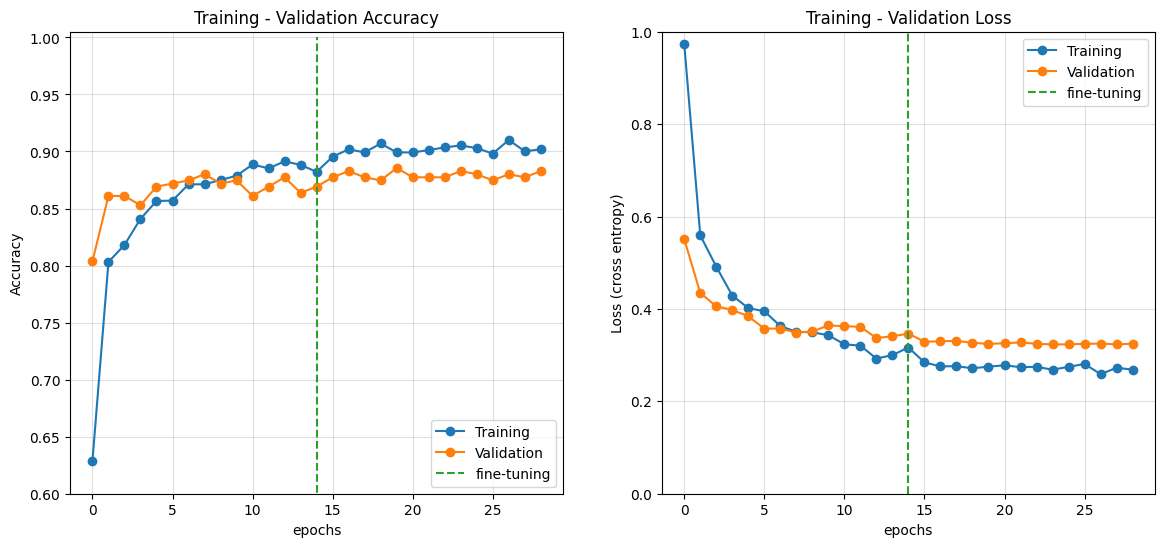

In [ ]:
plot_history_fined(history, history_finetune)